U-Net是一种专为生物医学图像分割设计的卷积神经网络架构，由Olaf Ronneberger等人在2015年的论文["U-Net: Convolutional Networks for Biomedical Image Segmentation"](https://arxiv.org/abs/1505.04597)中提出。它的名字来源于其U形的网络结构，主要创新点是通过跳跃连接(skip connections)将编码器路径的特征图与解码器路径的对应特征图融合，从而保留了不同尺度的空间信息，特别适合分割任务。

### 结构细节

U-Net的核心结构分为两部分：

1. **编码器(收缩路径)**：类似于传统的卷积神经网络，由卷积层、ReLU激活函数和最大池化层组成，用于捕获图像的上下文信息和特征表示。每一次下采样操作都会减少空间维度(高度和宽度)，同时增加通道数。

2. **解码器(扩展路径)**：通过反卷积(转置卷积)或上采样操作逐步恢复图像的空间维度，同时减少通道数。关键是解码器中的每一步都会与编码器部分的对应特征图进行拼接(concatenation)，这种跳跃连接能够将低级的空间细节信息与高级的语义信息结合起来。

3. **瓶颈层**：编码器和解码器之间的过渡部分，进一步提取高级特征。

4. **输出层**：通常使用1x1卷积将特征映射转换为所需的类别数，然后应用softmax或sigmoid激活函数进行像素级分类。

U-Net的一个重要特点是它能够用相对较少的训练样本实现良好的分割效果，这得益于其对称的U形结构和跳跃连接的设计。

### 代码示例

下面是一个使用PyTorch实现的U-Net模型示例：

```python
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """(卷积 => [批量归一化] => ReLU激活) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """下采样：最大池化后接双卷积"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """上采样：上采样后接双卷积"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # 如果使用双线性插值，则使用普通卷积减少通道数
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # 处理尺寸不匹配问题
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        # 拼接特征图（跳跃连接）
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """输出卷积：1x1卷积，用于生成最终的分割图"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """U-Net模型：用于图像分割的编码器-解码器架构"""
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels  # 输入图像的通道数
        self.n_classes = n_classes  # 输出分割图的类别数
        self.bilinear = bilinear  # 是否使用双线性插值进行上采样

        # 编码器部分
        self.inc = DoubleConv(n_channels, 64)  # 输入层
        self.down1 = Down(64, 128)  # 第一个下采样块
        self.down2 = Down(128, 256)  # 第二个下采样块
        self.down3 = Down(256, 512)  # 第三个下采样块
        factor = 2 if bilinear else 1  # 如果使用双线性插值，通道数减半
        self.down4 = Down(512, 1024 // factor)  # 瓶颈层
        
        # 解码器部分
        self.up1 = Up(1024, 512 // factor, bilinear)  # 第一个上采样块
        self.up2 = Up(512, 256 // factor, bilinear)  # 第二个上采样块
        self.up3 = Up(256, 128 // factor, bilinear)  # 第三个上采样块
        self.up4 = Up(128, 64, bilinear)  # 第四个上采样块
        self.outc = OutConv(64, n_classes)  # 输出层

    def forward(self, x):
        # 编码器路径，保存中间特征图用于跳跃连接
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # 解码器路径，结合编码器的特征图
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # 输出最终的分割图（未经过激活函数，通常在训练时使用nn.CrossEntropyLoss）
        logits = self.outc(x)
        return logits
```

### 代码说明

这个实现包含了几个关键组件：

1. **DoubleConv**：连续的两个卷积-BN-ReLU块，构成了U-Net中基本的特征提取单元。

2. **Down**：下采样模块，使用最大池化后跟DoubleConv。

3. **Up**：上采样模块，可以使用双线性插值或转置卷积进行上采样，然后与编码器部分的特征图拼接并通过DoubleConv处理。

4. **OutConv**：输出层，使用1x1卷积将特征映射转换为类别数。

5. **UNet**：主模型类，组织了完整的编码器-解码器结构，包括跳跃连接。

模型的输入是`n_channels`通道的图像，输出是`n_classes`通道的分割结果。在生物医学分割任务中，`n_classes`通常为2(前景和背景)。

这个实现支持使用双线性插值或转置卷积进行上采样，可以通过`bilinear`参数控制。跳跃连接通过将编码器和解码器的特征图在通道维度上拼接实现，确保低级细节信息能够帮助恢复精确的分割边界。

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils import data  
import numpy as np 
import matplotlib.pyplot as plt 
import torchvision
from torchvision import transforms
import os
import glob 
from PIL import Image

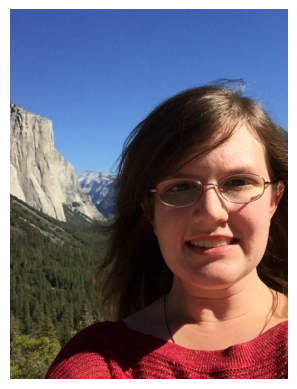

In [2]:
demo_img = Image.open('HKdataset/HKdataset/training/00001.png')
plt.axis('off')
plt.imshow(demo_img)

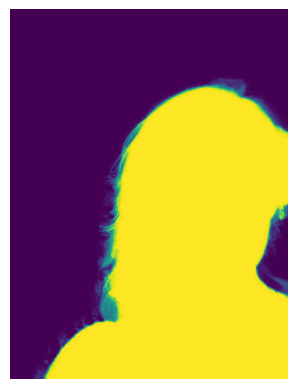

In [3]:
demo_img_matte = Image.open('HKdataset/HKdataset/training/00001_matte.png')
plt.axis('off')
plt.imshow(demo_img_matte)

In [7]:
np.unique(demo_img_matte)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [9]:
np.array(demo_img_matte).max()

255

In [10]:
np.array(demo_img_matte).min() 

0

发现并不是只包含两种像素,而是全像素0-255色

In [5]:
demo_img_matte = np.array(demo_img_matte)

In [6]:
demo_img_matte[demo_img_matte>0] = 1 

让大于0的都置为1

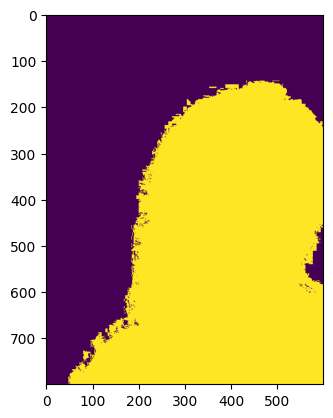

In [7]:
plt.imshow(demo_img_matte)

In [14]:
demo_img_matte.max() 

1

In [15]:
demo_img_matte.min() 

0

这时候就只有两个类别颜色了

In [17]:
np.unique(demo_img_matte)

array([0, 1], dtype=uint8)

In [18]:
demo_img_matte.shape

(800, 600)

## 创建dataset

In [8]:
all_pics = glob.glob('HKdataset/HKdataset/training/*.png')

In [9]:
all_pics[:5]

['HKdataset/HKdataset/training\\00001.png',
 'HKdataset/HKdataset/training\\00001_matte.png',
 'HKdataset/HKdataset/training\\00002.png',
 'HKdataset/HKdataset/training\\00002_matte.png',
 'HKdataset/HKdataset/training\\00003.png']

In [10]:
imgs = [pic for pic in all_pics if 'matte' not in pic] #拿到原图

In [11]:
imgs[:5]

['HKdataset/HKdataset/training\\00001.png',
 'HKdataset/HKdataset/training\\00002.png',
 'HKdataset/HKdataset/training\\00003.png',
 'HKdataset/HKdataset/training\\00004.png',
 'HKdataset/HKdataset/training\\00005.png']

In [12]:
imgs_matted = [p for p in all_pics if 'matte' in p] #拿到蒙版图

In [13]:
imgs_matted[:5]

['HKdataset/HKdataset/training\\00001_matte.png',
 'HKdataset/HKdataset/training\\00002_matte.png',
 'HKdataset/HKdataset/training\\00003_matte.png',
 'HKdataset/HKdataset/training\\00004_matte.png',
 'HKdataset/HKdataset/training\\00005_matte.png']

In [14]:
len(imgs),len(imgs_matted)

(1700, 1700)

In [15]:
seed = np.random.seed(2025)  
randidx = np.random.permutation(len(imgs)) 

进行乱序

In [16]:
imgs = np.array(imgs)[randidx] 
imgs_matted = np.array(imgs_matted)[randidx]

In [17]:
imgs[:5],imgs_matted[:5]

(array(['HKdataset/HKdataset/training\\00836.png',
        'HKdataset/HKdataset/training\\01420.png',
        'HKdataset/HKdataset/training\\00772.png',
        'HKdataset/HKdataset/training\\00866.png',
        'HKdataset/HKdataset/training\\00454.png'], dtype='<U38'),
 array(['HKdataset/HKdataset/training\\00836_matte.png',
        'HKdataset/HKdataset/training\\01420_matte.png',
        'HKdataset/HKdataset/training\\00772_matte.png',
        'HKdataset/HKdataset/training\\00866_matte.png',
        'HKdataset/HKdataset/training\\00454_matte.png'], dtype='<U44'))

In [18]:
all_test_pics = glob.glob('HKdataset/HKdataset/testing/*.png')

In [19]:
test_imgs = [p for p in all_test_pics if 'matte' not in p]
test_imgs_matted = [ p for p in all_test_pics if 'matte' in p] 

In [20]:
test_imgs[:5],test_imgs_matted[:5]

(['HKdataset/HKdataset/testing\\00001.png',
  'HKdataset/HKdataset/testing\\00002.png',
  'HKdataset/HKdataset/testing\\00003.png',
  'HKdataset/HKdataset/testing\\00004.png',
  'HKdataset/HKdataset/testing\\00005.png'],
 ['HKdataset/HKdataset/testing\\00001_matte.png',
  'HKdataset/HKdataset/testing\\00002_matte.png',
  'HKdataset/HKdataset/testing\\00003_matte.png',
  'HKdataset/HKdataset/testing\\00004_matte.png',
  'HKdataset/HKdataset/testing\\00005_matte.png'])

## 创建dataset

In [21]:
transform_all = transforms.Compose(
    [
        transforms.Resize((128,128)), 
        transforms.ToTensor()
    ]
) 

In [42]:
class HKdataset(data.Dataset): 
    def __init__(self,img_path,img_matte_path,transform): 
        self.img_path = img_path
        self.img_matte_path = img_matte_path
        self.transform = transform
    def __len__(self): 
        return len(self.img_path)
    def __getitem__(self,idx): 
        img = self.img_path[idx]
        pil_img = Image.open(img).convert('RGB')

        matted_img = self.img_matte_path[idx]  
        pil_img_matted = Image.open(matted_img).convert('L')
        np_img = np.array(pil_img_matted)
        np_img[np_img>0] = 1
        matte_img = Image.fromarray(np_img.astype(np.uint8))
        if self.transform: 
            img = self.transform(pil_img)
            matte_img = self.transform(matte_img)  
         #确保matte是正确的形状和类型
        # 如果matte是(C,H,W)且C=1，移除通道维度
        if len(matte_img.shape) == 3 and matte_img.shape[0] == 1:
            matte_img = matte_img.squeeze(0)  # 明确移除通道维度
        matte_img = matte_img.type(torch.long)
        return img,matte_img

In [ ]:
class HKdataset(data.Dataset): 
    def __init__(self, img_path, img_matte_path, transform): 
        self.img_path = img_path
        self.img_matte_path = img_matte_path
        self.transform = transform

    def __len__(self): 
        return len(self.img_path)

    def __getitem__(self, idx): 
        # 处理原始图像（RGB）
        img_path = self.img_path[idx]
        pil_img = Image.open(img_path).convert('RGB')  # 得到 PIL 图像

        # 处理 matte 图像（二值化）
        matte_path = self.img_matte_path[idx]
        pil_matte = Image.open(matte_path).convert('L')  # 先转为灰度 PIL 图像
        np_matte = np.array(pil_matte)  # 转为 NumPy 数组
        np_matte[np_matte > 0] = 1  # 二值化（0=背景，1=前景）
        # 关键：将 NumPy 数组转回 PIL 图像（确保 transform 能处理）
        pil_matte_processed = Image.fromarray(np_matte.astype(np.uint8))

        # 应用 transform（此时输入都是 PIL 图像，符合要求）
        if self.transform: 
            img = self.transform(pil_img)  # 处理 RGB 图像
            matte_img = self.transform(pil_matte_processed)  # 处理 matte 图像

        # 调整 matte 格式（移除多余维度，转为长整数类型）
        matte_img = torch.squeeze(matte_img).type(torch.long)
        return img, matte_img

In [22]:
class HKdataset(data.Dataset): 
    def __init__(self, img_path, img_matte_path, transform): 
        self.img_path = img_path
        self.img_matte_path = img_matte_path
        self.transform = transform

    def __len__(self): 
        return len(self.img_path)

    def __getitem__(self, idx): 
        img = self.img_path[idx] 
        anno = self.img_matte_path[idx] 
        pil_img = Image.open(img) 
        img_tensor = self.transform(pil_img) 

        anno_img = Image.open(anno)  
        anno_tensor = self.transform(anno_img)  
        anno_tensor[anno_tensor>0] = 1
        anno_tensor = torch.squeeze(anno_tensor).type(torch.long)
        return img_tensor,anno_tensor

## 创建trainds,traindl等

In [23]:
train_ds = HKdataset(
    imgs, 
    imgs_matted, 
    transform_all
)

In [24]:
test_ds = HKdataset(
    test_imgs, 
    test_imgs_matted, 
    transform_all
)

In [25]:
train_dl = data.DataLoader(train_ds,batch_size=16,shuffle=True)
test_dl = data.DataLoader(test_ds,batch_size=16)

In [26]:
demo_batch,demo_matte = next(iter(train_dl))

In [27]:
demo_batch.shape

torch.Size([16, 3, 128, 128])

In [28]:
demo_matte.shape

torch.Size([16, 128, 128])

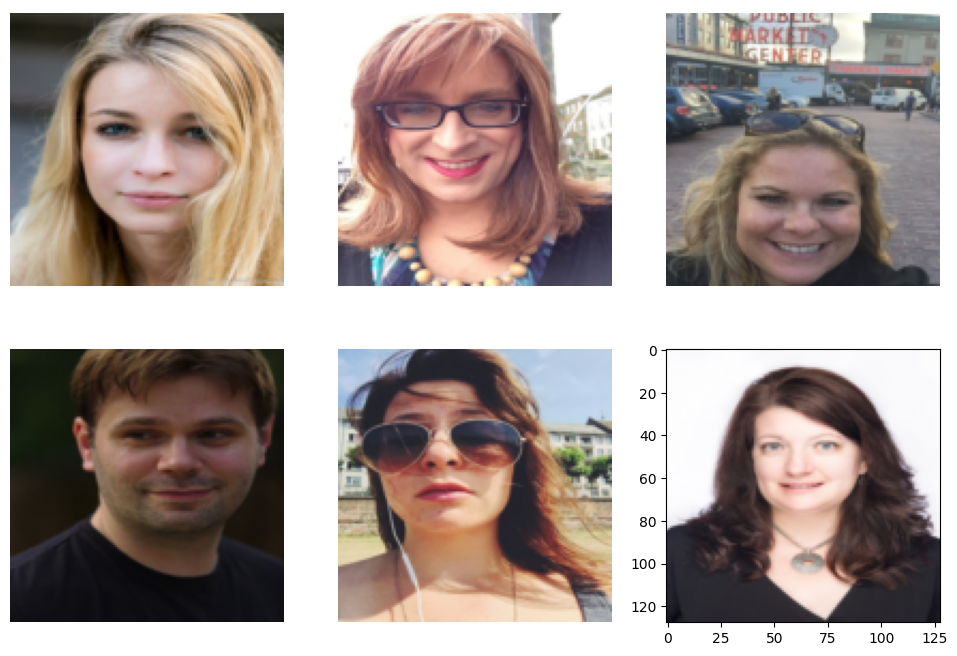

In [29]:
plt.figure(figsize=(12,8)) 
for i in range(6):  
    plt.axis('off')
    plt.subplot(2,3,i+1) 
    plt.imshow(demo_batch[i].permute(1,2,0).numpy())

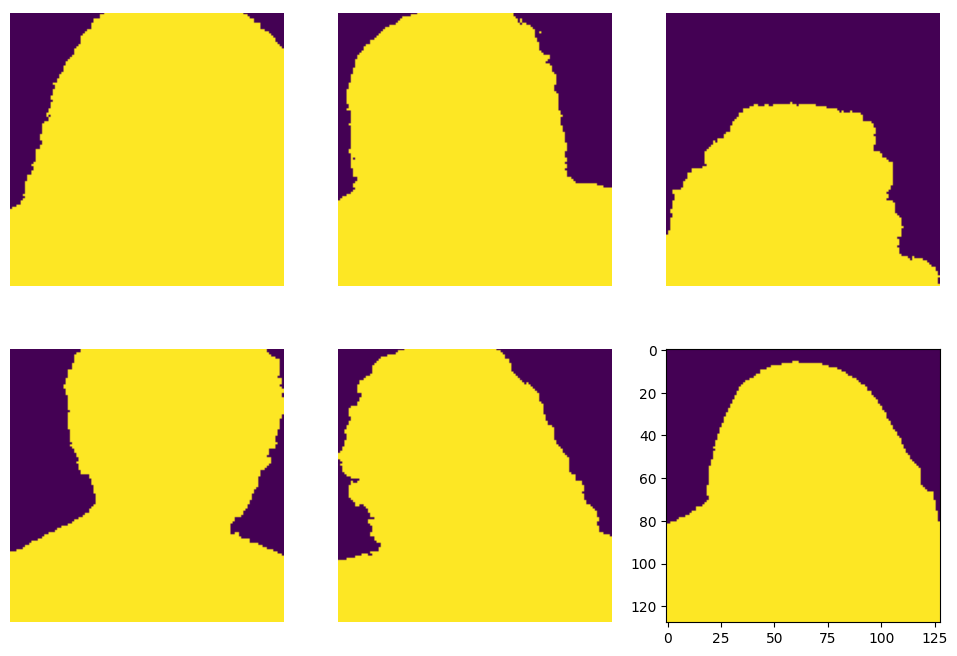

In [30]:
plt.figure(figsize=(12,8)) 
for i in range(6):  
    plt.axis('off')
    plt.subplot(2,3,i+1) 
    plt.imshow(demo_matte[i].numpy())

In [31]:
demo_matte[0].min().item() 

0

In [32]:
demo_matte[0].max().item() 

1

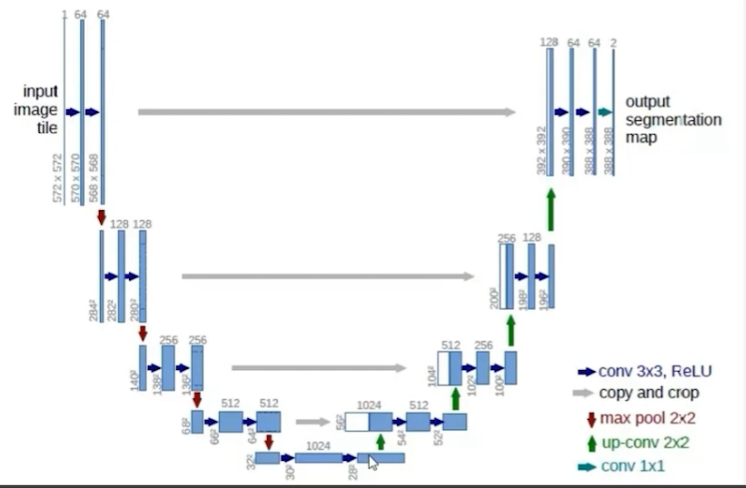

## 编写下采样模型

In [33]:
class Downsample(nn.Module): 
    def __init__(self,in_channels,out_channels):  
        super().__init__()  
        self.conv_relu = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.ReLU(),  
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            nn.ReLU(), 
        )
        self.pool = nn.MaxPool2d(kernel_size=2)
    def forward(self,x,is_pool=True):  
        if is_pool:  
            x = self.pool(x)  
        x = self.conv_relu(x)
        return x   

## 编写上采样模型

In [34]:
class Upsample(nn.Module):  
    def __init__(self,channels):  
        super().__init__()  
        self.conv_relu = nn.Sequential(
            nn.Conv2d(
                2*channels,
                channels,
                kernel_size=3, 
                padding=1
            ), 
            nn.ReLU(),
            nn.Conv2d(
                channels, 
                channels, 
                kernel_size=3,  
                padding=1
            ),    
            nn.ReLU()
        )
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(  #反卷积
                channels, 
                channels//2, 
                kernel_size=2,  
                stride=2, 
                output_padding=0,
            )
        )
    def forward(self,x): 
        x = self.conv_relu(x)  
        x = self.upconv(x)  
        return x  
        

In [125]:
class Unet(nn.Module):  
    def __init__(self):  
        super().__init__()  
        self.down1 = Downsample(in_channels=3,out_channels=64)  
        self.down2 = Downsample(in_channels=64,out_channels=128)  
        self.down3 = Downsample(in_channels=128,out_channels=256)  
        self.down4 = Downsample(in_channels=256,out_channels=512)  
        self.down5 = Downsample(in_channels=512,out_channels=1024)  

        self.up= nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024,  
                out_channels=512, 
                kernel_size=2,
                stride=2
            ),
            nn.ReLU()
        )

        self.up1 = Upsample(channels=512)
        self.up2 = Upsample(channels=256)
        self.up3 = Upsample(channels=128)

        self.conv2 = Downsample(in_channels=128,out_channels=64)
        # 新增：最后一次上采样，确保输出尺寸为256×256
        self.final_up = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.lastout = nn.Conv2d(in_channels=64,out_channels=2,kernel_size=1)  

    def forward(self,x): 
        x1 = self.down1(x,is_pool=False) 
        x2 = self.down2(x1)  
        x3 = self.down3(x2)  
        x4 = self.down4(x3)  
        x5 = self.down5(x4)  

        x5= self.up(x5)  
        x5 = torch.cat([x4,x5],1)

        x5 = self.up1(x5)  
        x5 = torch.cat([x3,x5],1)  

        x5 = self.up2(x5)  
        x5 = torch.cat([x2,x5],1)  
        
        x5 = self.up3(x5)
        x5 = torch.cat([x1,x5],1)  

        x5 = self.conv2(x5)
        x5 = self.final_up(x5)            # 确保最终尺寸为256×256（若需要）
        x5 = self.lastout(x5) 

        return x5
      

In [140]:
class Unet(nn.Module):  
    def __init__(self):  
        super().__init__()  
        # 编码器：减少为3次下采样（原4次）
        self.down1 = Downsample(in_channels=3, out_channels=64)  # 不池化，尺寸128→128
        self.down2 = Downsample(in_channels=64, out_channels=128)  # 池化，尺寸128→64
        self.down3 = Downsample(in_channels=128, out_channels=256)  # 池化，尺寸64→32
        self.down4 = Downsample(in_channels=256, out_channels=512)  # 池化，尺寸32→16（最后一层）

        # 解码器：对应3次上采样
        self.up = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 尺寸16→32
            nn.ReLU()
        )

        self.up1 = Upsample(channels=256)  # 尺寸32→64
        self.up2 = Upsample(channels=128)  # 尺寸64→128（恢复输入尺寸）

        # 最终卷积：调整通道数
        self.last_conv = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 保持尺寸
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=1)  # 输出2类
        )

    def forward(self, x): 
        # 编码器：下采样过程
        x1 = self.down1(x, is_pool=False)  # 尺寸：128→128
        x2 = self.down2(x1)                # 尺寸：128→64
        x3 = self.down3(x2)                # 尺寸：64→32
        x4 = self.down4(x3)                # 尺寸：32→16

        # 解码器：上采样过程
        x5 = self.up(x4)                   # 尺寸：16→32（与x3匹配）
        x5 = torch.cat([x3, x5], dim=1)    # 拼接跳跃连接

        x5 = self.up1(x5)                  # 尺寸：32→64（与x2匹配）
        x5 = torch.cat([x2, x5], dim=1)

        x5 = self.up2(x5)                  # 尺寸：64→128（与x1匹配）
        x5 = torch.cat([x1, x5], dim=1)

        # 最终卷积：调整通道数，保持尺寸128×128
        x5 = self.last_conv(x5)
        return x5

In [35]:
class Unet(nn.Module):  
    def __init__(self):  
        super().__init__()  
        # 编码器：使用更小的通道数（原64→32, 128→64, 256→128, 512→256）
        self.down1 = Downsample(in_channels=3, out_channels=32)  # 不池化，128→128
        self.down2 = Downsample(in_channels=32, out_channels=64)  # 池化，128→64
        self.down3 = Downsample(in_channels=64, out_channels=128)  # 池化，64→32
        self.down4 = Downsample(in_channels=128, out_channels=256)  # 池化，32→16

        # 解码器：对应更小的通道数
        self.up = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 16→32
            nn.ReLU()
        )

        self.up1 = Upsample(channels=128)  # 32→64
        self.up2 = Upsample(channels=64)  # 64→128

        # 最终卷积：调整通道数
        self.last_conv = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size=1)  # 输出2类
        )

    def forward(self, x): 
        x1 = self.down1(x, is_pool=False)  # 128→128
        x2 = self.down2(x1)                # 128→64
        x3 = self.down3(x2)                # 64→32
        x4 = self.down4(x3)                # 32→16

        x5 = self.up(x4)                   # 16→32
        x5 = torch.cat([x3, x5], dim=1)    # 拼接

        x5 = self.up1(x5)                  # 32→64
        x5 = torch.cat([x2, x5], dim=1)

        x5 = self.up2(x5)                  # 64→128
        x5 = torch.cat([x1, x5], dim=1)

        x5 = self.last_conv(x5)            # 128→128
        return x5

In [36]:
mymodel = Unet() 

In [37]:
mymodel

Unet(
  (down1): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [38]:
optimizer = torch.optim.Adam(mymodel.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss() #采用交叉熵损失

In [ ]:
def fit_gpu(Train_DL, TST_DL, Model_m, epoch_, optim, loss_fn):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
    
    # 训练阶段
    Model_m.train()
    train_correct = 0
    train_total = 0
    train_loss = 0
    
    for x, y in Train_DL:
        # 数据移至设备
        x, y = x.to(device), y.to(device)
        
        # 前向传播
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        
        # 反向传播
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # 计算训练准确率 (像素级)
        preds = torch.argmax(y_pred, dim=1)
        train_correct += (preds == y).sum().item()
        train_total += y.numel()  # 总像素数
        train_loss += loss.item()
    
    train_epoch_loss = train_loss / len(Train_DL)
    train_epoch_acc = train_correct / train_total
    
    # 测试阶段
    Model_m.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0
    
    with torch.no_grad():
        for x, y in TST_DL:
            x, y = x.to(device), y.to(device)
            y_pred = Model_m(x)
            loss = loss_fn(y_pred, y)
            
            preds = torch.argmax(y_pred, dim=1)
            test_correct += (preds == y).sum().item()
            test_total += y.numel()
            test_loss += loss.item()
    
    test_epoch_loss = test_loss / len(TST_DL)
    test_epoch_acc = test_correct / test_total
    
    # 打印训练结果
    print(
        f'Epoch {epoch_} | Train Loss: {train_epoch_loss:.3f} | Train Acc: {train_epoch_acc:.3f} | '
        f'Test Loss: {test_epoch_loss:.3f} | Test Acc: {test_epoch_acc:.3f}'
    )
    
    return train_epoch_loss, train_epoch_acc, test_epoch_loss, test_epoch_acc

In [41]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
  
    Model_m.train()  # 设置为训练模式,此时dropout层会发挥作用
    for x, y in Train_DL:
        
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
        # 所有 batch 都训练完后，再计算整个 epoch 的准确率和损失
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)  #沿着类别维度找到最大值的索引位置
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了等式可以数值操作,我们用.item()取值
            total += y.size(0) #样本的个数,也就是size返回值的第一个返回值,即行数
            running_loss += loss.item()

        
    epoch_acc = correct/(total*256*256) #因为对比的是像素的iou
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval() #转为eval()模式,此时dropout层不会起作用
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             #注意这里有变化
             y = torch.tensor(y,dtype=torch.long)
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/(tsttotal*256*256)
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc


In [39]:
from torch.cuda.amp import GradScaler, autocast

def fit_gpu(Train_DL, TST_DL, Model_m, epoch_, optim, loss_fn):
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
    scaler = GradScaler()  # 梯度缩放器

    for epoch in range(epoch_):
        # 训练阶段
        Model_m.train()
        for x, y in Train_DL:
            x, y = x.to(device), y.to(device, dtype=torch.long)
            
            # 混合精度：前向传播用float16
            with autocast():
                y_pred = Model_m(x)
                loss = loss_fn(y_pred, y)
            
            # 反向传播：用scaler处理梯度
            optim.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            
            # 清理显存
            del x, y, y_pred, loss
            torch.cuda.empty_cache()
        
        # 验证阶段（类似，可不用混合精度）
        # ...
          #测试阶段 
    Model_m.eval() #转为eval()模式,此时dropout层不会起作用
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             #注意这里有变化
             y = torch.tensor(y,dtype=torch.long)
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/(tsttotal*256*256)
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc


In [ ]:

from torch.optim.lr_scheduler import StepLR
import copy
best_state = copy.deepcopy(model.state_dict()) 
best_acc = 0 
scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.9) #设置指定的优化器衰减策略,每5个epoch衰减一次,指定每次的被乘因子为0.9
train_loss_gpu = []
train_acc_gpu = []
tst_loss_gpu = []
tst_acc_gpu = []
epochs = 10

for epoch in range(epochs):
      # 每个 epoch 都训练
    epoch_loss, epoch_acc, tstepoch_loss, tstepoch_acc = fit_gpu(
        Train_DL=train_dl,
        TST_DL=test_dl,
        Model_m=mymodel,
        epoch_=epoch,
        optim=optimizer,
        loss_fn=loss_fn
    )
    #如果测试集的精确度大于最优精确度的话就更新精确度
    if tstepoch_acc > best_acc: 
        best_state = copy.deepcopy(model.state_dict())
        best_acc = epoch_acc
    # 记录指标
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: 学习率已更新为 {current_lr:.2e}")

In [45]:
img_batch,mask_batch = next(iter(test_dl))

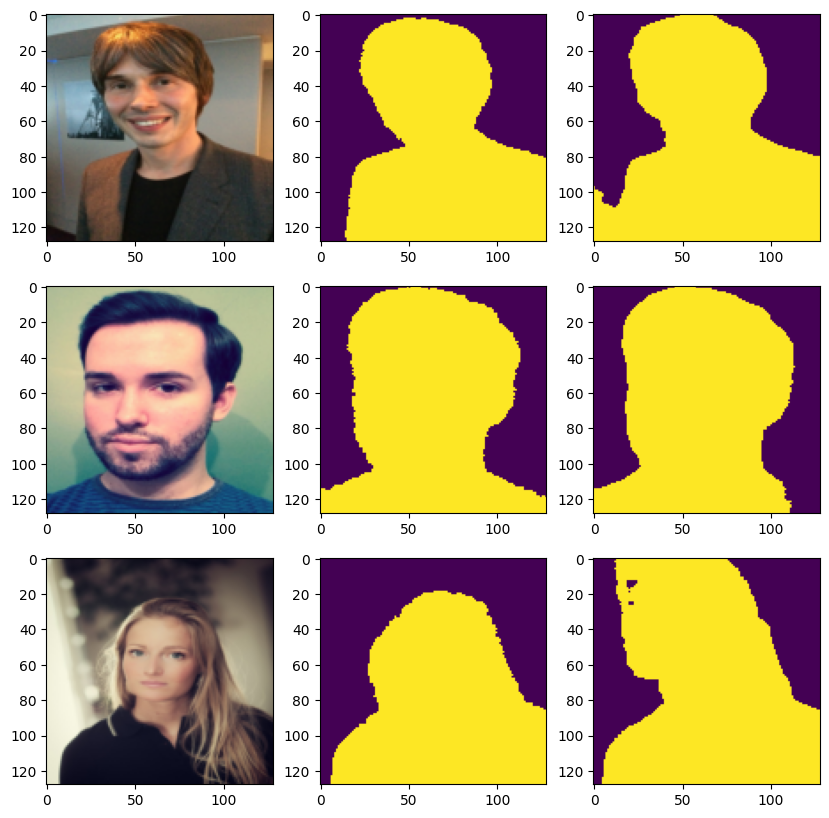

In [51]:
# 假设模型已经在GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mymodel = mymodel.to(device)
# 将输入数据也移到相同的设备上
img_batch = img_batch.to(device)
pred_batch = mymodel(img_batch)
plt.figure(figsize=(10,10))  
num=3
for i in range(num):  
    plt.subplot(3,3,i*num+1) 
    plt.imshow(img_batch[i].permute(1,2,0).cpu().numpy())  
    plt.subplot(3,3,i*num+2)   
    plt.imshow(mask_batch[i].cpu().numpy()) 
    plt.subplot(3,3,i*num+3)  
    pred_pic = torch.argmax(pred_batch[i].permute(1,2,0),axis=-1).detach().cpu().numpy()
    plt.imshow(pred_pic)
    

In [54]:
mymodel.eval()  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
mymodel.to(device)  
example_input = torch.rand(1,3,128,128).to(device)  
traced_model = torch.jit.trace(mymodel,example_input)  

traced_model.save('./model/unetmy.pt')

In [55]:
test_pic = Image.open('ngzk.png')
pic_tensor = transform_all(test_pic)  

In [56]:
pic_tensor.shape

torch.Size([4, 128, 128])

In [57]:
img_tensor_b = torch.unsqueeze(pic_tensor,0)

In [61]:
img_tensor_b = img_tensor_b[:, :3, :, :] 

In [62]:
img_tensor_b.shape

torch.Size([1, 3, 128, 128])

In [68]:
mymodel.to(device)
img_tensor_b = img_tensor_b.to(device)
pred = mymodel(img_tensor_b)

In [69]:
pred.shape

torch.Size([1, 2, 128, 128])

In [70]:
pred_pic = torch.argmax(pred[0].permute(1,2,0),axis=-1).detach().cpu().numpy()

(-0.5, 127.5, 127.5, -0.5)

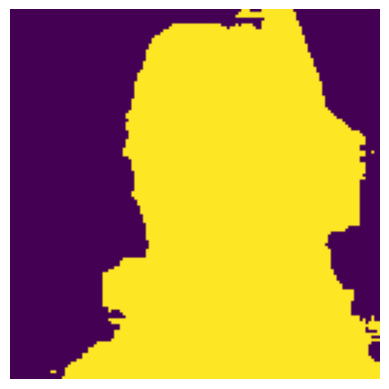

In [81]:
plt.imshow(pred_pic)
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

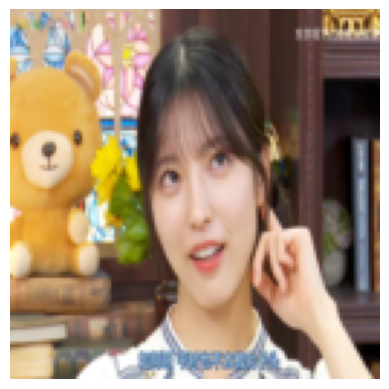

In [80]:
plt.imshow(img_tensor_b[0].permute(1,2,0).cpu().numpy())
plt.axis('off')